In [1]:
import os 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import sys
sys.path.append("..")

from make_dir import mkdir
from load_yaml import get_yaml

import models.bgk_net as solutions
import equations.bgk_eqn as equation

from bgk_dataset import Sampler
import bgk_solver as solver 

import matplotlib.pyplot as plt
import time


In [2]:
# load config
current_path = os.path.abspath(".")
yaml_path = os.path.join(current_path, "bgk.yaml")
Config = get_yaml(yaml_path)

# load reference data
absolute_path = os.path.abspath("..")
ref_path = os.path.join(absolute_path, "data/dirichlet_ref_kn1e0.npz")
ref = np.load(ref_path)
time_freq = 1
ref_rho = ref["density"][::time_freq].astype("float32").reshape(-1, 1) # shape: (100, 1)
ref_momentum = ref["momentum"][::time_freq].astype("float32").reshape(-1, 1)
ref_energy = ref["energy"][::time_freq].astype("float32").reshape(-1, 1)

In [3]:
time_dimension = Config["physical_config"]["time_dimension"]
space_dimension = Config["physical_config"]["space_dimension"]
velocity_dimension = Config["physical_config"]["velocity_dimension"]

d1_in = time_dimension + space_dimension + velocity_dimension
d2_in = time_dimension + space_dimension

layers_f = Config["model_config"]["units_f"]
layers_rho = Config["model_config"]["units_rho"]
layers_u = Config["model_config"]["units_u"]
layers_T = Config["model_config"]["units_T"]

# build neural networks for f, rho, u, T
Model_f = "solutions.Model_f_" + "{}".format(Config["model_config"]["neural_network_type"])
Model_f = eval(Model_f)

Model_rho = "solutions.Model_rho_" + "{}".format(Config["model_config"]["neural_network_type"])
Model_rho = eval(Model_rho)

Model_u = "solutions.Model_u_" + "{}".format(Config["model_config"]["neural_network_type"])
Model_u = eval(Model_u)

Model_T = "solutions.Model_T_" + "{}".format(Config["model_config"]["neural_network_type"])
Model_T = eval(Model_T)

model_f = Model_f(input_size = d1_in, layers = layers_f, output_size = 1)
model_rho = Model_rho(input_size = d2_in, layers = layers_rho, output_size = 1)
model_u = Model_u(input_size = d2_in, layers = layers_u, output_size = 1)
model_T = Model_T(input_size = d2_in, layers = layers_T, output_size = 1)

device_ids = Config["model_config"]["device_ids"]
device = torch.device("cuda:{:d}".format(device_ids[0]) if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:    
    model_f = nn.DataParallel(model_f, device_ids = device_ids)
    model_rho = nn.DataParallel(model_rho, device_ids = device_ids)
    model_u = nn.DataParallel(model_u, device_ids = device_ids)
    model_T = nn.DataParallel(model_T, device_ids = device_ids)
    
model_f.to(device)
model_rho.to(device)
model_u.to(device)
model_T.to(device)



DataParallel(
  (module): Model_T_ResNet(
    (_layer_in): Linear(in_features=2, out_features=64, bias=True)
    (_residual_blocks): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ResidualBlock(
        (_layers): ModuleList(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (2): ResidualBlock(
        (_layers): ModuleList(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (3): Linear(in_features=64, out_features=1, bias=True)
    )
    (_output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [4]:
# number of paramerters
param_num_1 = sum(neural.numel() for neural in model_f.parameters())
param_num_2 = sum(neural.numel() for neural in model_rho.parameters())
param_num_3 = sum(neural.numel() for neural in model_u.parameters())
param_num_4 = sum(neural.numel() for neural in model_T.parameters())
print("Number of paramerters for networks f, rho, u, T is: {:6d}, {:6d}, {:6d}, {:6d}. ".format(
    param_num_1, param_num_2, param_num_3, param_num_4))


Number of paramerters for networks f, rho, u, T is:  66689,  16897,  16897,  16897. 


In [5]:
solutions.Xavier_initi(model_f)
solutions.Xavier_initi(model_rho)
solutions.Xavier_initi(model_u)
solutions.Xavier_initi(model_T)


In [6]:
# make plot
def plot(iter):
    xmin = Config["physical_config"]["x_range"][0]
    xmax = Config["physical_config"]["x_range"][1]
    tmax = Config["physical_config"]["t_range"][1]

    nx = 100
    dx = float(xmax - xmin) / nx
    ref_x = torch.arange(xmin + dx / 2, xmax + dx / 2, dx).reshape((-1, 1))
    ref_t = tmax * torch.ones((nx, 1))

    model_rho, model_u, model_T = Sol[1:]
    rho_approx = model_rho(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
    u_approx = model_u(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
    T_approx = model_T(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
    approx_density = rho_approx
    approx_momentum = rho_approx * u_approx
    approx_energy = 0.5 * rho_approx * (u_approx**2 + T_approx)

    plt.plot(ref_x, ref_rho, "r", label = "density")
    plt.plot(ref_x, ref_momentum, "k", label = "momentum")
    plt.plot(ref_x, ref_energy, "g", label = "energy")

    plt.plot(ref_x, approx_density, "r*", markevery= 4, label = "approx density")
    plt.plot(ref_x, approx_momentum, "k+", markevery= 4, label = "approx momentum")
    plt.plot(ref_x, approx_energy, "gx", markevery= 4, label = "approx energy")
    plt.grid()
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("macro")
    plt.title("Approximate density, momentum, energy and reference solutions")
    plt.savefig("./figure/solution_iter_{:d}.pdf".format(iter))
    # plt.show()
    plt.close()


In [7]:
# Set optimizer and learning rate decay
optimizer = optim.Adam([
    {'params': model_f.parameters()},
    {'params': model_rho.parameters()},
    {'params': model_u.parameters()},
    {'params': model_T.parameters()}
],  lr=Config["model_config"]["lr"])

scheduler = lr_scheduler.StepLR(
    optimizer, Config["model_config"]["stage_num"], Config["model_config"]["decay_rate"])



In [9]:
Sol = [model_f, model_rho, model_u, model_T]
eqn = equation.BGK(config = Config, sol = Sol)

Iter = Config["model_config"]["iterations"] 
regularizers = Config["model_config"]["regularizers"]

loss_record, error_record = np.array([[]]).T, np.array([[]]*3).T

mkdir(file_dir = "./model_saved")
mkdir(file_dir = "./record")
mkdir(file_dir = "./figure")

time_start = time.time()
print('Begin training.')
print('')
for it in range(Iter):
    
    sampler = Sampler(Config)
    trainloader = [sampler.interior(), sampler.boundary(), sampler.initial()]
        
    risk, error = solver.train_step(sol = Sol,
                                    trainloader = trainloader, 
                                    equation = eqn,  
                                    regularizers = regularizers,
                                    optimizer = optimizer, 
                                    scheduler = scheduler,
                                    ref = ref)
    
    loss = risk["total_loss"]
    res_bgk_eqn = risk["bgk"]
    res_conservation_eqn_1 = risk["conservation"][0]
    res_conservation_eqn_2 = risk["conservation"][1]
    res_conservation_eqn_3 = risk["conservation"][2]

    res_relaxation_eqn_1 = risk["relaxation"][0]
    res_relaxation_eqn_2 = risk["relaxation"][1]
    res_relaxation_eqn_3 = risk["relaxation"][2]

    res_bc_rho = risk["bc_rho"]
    res_bc_u = risk["bc_u"]
    res_bc_T = risk["bc_T"]

    res_ic_rho = risk["ic_rho"]
    res_ic_u = risk["ic_u"]
    res_ic_T = risk["ic_T"]
    res_ic_f = risk["ic_f"]

    error = error["macro_error"] 

    error = np.array(error, dtype=float).reshape(1, -1)
    loss_record = np.concatenate((loss_record, loss*np.ones((1, 1))), axis=0)
    error_record = np.concatenate((error_record, error), axis=0)

    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    if it % 100 == 0:
    
        print("[Iter: {:6d}/{:6d} - lr: {:.2e} and Loss: {:.2e}]".format(it + 1, Iter, lr, loss))
        print(
            "[Error for density: {:.2e} - momentum: {:.2e} - energy: {:.2e}]".format(
                float(error[:, 0]), float(error[:, 1]), float(error[:, 2])
            )
        )
        print(
            "[BGK eqn: {:.2e} and Conservation - density: {:.2e} - momentum: {:.2e} - energy: {:.2e}]".format(
                res_bgk_eqn,
                res_conservation_eqn_1, 
                res_conservation_eqn_2, 
                res_conservation_eqn_3
            )
        )
        print(
            "[Relaxation - rho: {:.2e} - u: {:.2e} - T: {:.2e}]".format(
                res_relaxation_eqn_1, 
                res_relaxation_eqn_2, 
                res_relaxation_eqn_3
            )
        )
        # print(
        #     "[Boundary - rho: {:.2e} - u: {:.2e} - T: {:.2e}]".format(
        #         res_bc_rho, res_bc_u, res_bc_T
        #     )
        # ) 
        print(
            "[Initial - rho: {:.2e} - u: {:.2e} - T: {:.2e} - f: {:.2e}]".format(
                res_ic_rho, res_ic_u, res_ic_T, res_ic_f
            )
        )
        
    if (it + 1) % 1000 == 0:
        plot(iter = it + 1) 
        
    if np.max(error) < 1e-2:
        print("Iteration step: ", it)
        break

np.savez("./record/result.npz",
         loss=loss_record,
         error_rho=error_record[:, 0],
         error_momentum=error_record[:, 1],
         error_energy=error_record[:, 2])

solutions.save_param(model_f, path = './model_saved/model_f_params.pkl')
solutions.save_param(model_rho, path = './model_saved/model_rho_params.pkl')
solutions.save_param(model_u, path = './model_saved/model_u_params.pkl')
solutions.save_param(model_T, path = './model_saved/model_T_params.pkl')

print("")
print("Finished training.")
time_end = time.time()
print("Total time is: {:.2e}".format(time_end - time_start), "seconds")



File has already exists!
File has already exists!
File has already exists!
Begin training.

[Iter:      1/ 50000 - lr: 8.00e-03 and Loss: 4.21e-01]
[Error for density: 9.35e-02 - momentum: 5.21e-01 - energy: 2.49e-01]
[BGK eqn: 1.70e-02 and Conservation - density: 1.40e-03 - momentum: 5.46e-03 - energy: 1.26e-03]
[Relaxation - rho: 2.71e-02 - u: 3.45e-02 - T: 2.47e-01]
[Initial - rho: 2.06e-03 - u: 1.86e-02 - T: 1.60e-03 - f: 3.24e-03]
[Iter:    101/ 50000 - lr: 8.00e-03 and Loss: 2.94e-01]
[Error for density: 7.62e-02 - momentum: 4.41e-01 - energy: 2.43e-01]
[BGK eqn: 1.39e-02 and Conservation - density: 5.35e-04 - momentum: 1.01e-02 - energy: 1.77e-03]
[Relaxation - rho: 3.64e-02 - u: 8.72e-03 - T: 1.58e-01]
[Initial - rho: 1.36e-03 - u: 5.85e-03 - T: 1.48e-03 - f: 3.01e-03]
[Iter:    201/ 50000 - lr: 8.00e-03 and Loss: 2.17e-01]
[Error for density: 7.64e-02 - momentum: 4.02e-01 - energy: 2.55e-01]
[BGK eqn: 1.11e-02 and Conservation - density: 1.22e-03 - momentum: 2.70e-02 - energy:

In [10]:
# # load model
# solutions.load_param(model_f, './model_saved/model_f_params.pkl')
# solutions.load_param(model_rho, './model_saved/model_rho_params.pkl')
# solutions.load_param(model_u, './model_saved/model_u_params.pkl')
# solutions.load_param(model_T, './model_saved/model_T_params.pkl')

Sol = [model_f, model_rho, model_u, model_T]


In [11]:
xmin = Config["physical_config"]["x_range"][0]
xmax = Config["physical_config"]["x_range"][1]
tmax = Config["physical_config"]["t_range"][1]

nx = 100
dx = float(xmax - xmin) / nx
ref_x = torch.arange(xmin + dx / 2, xmax + dx / 2, dx).reshape((-1, 1))
ref_t = tmax * torch.ones((nx, 1))


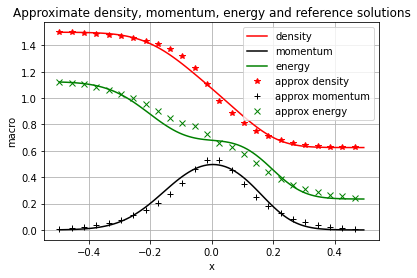

In [12]:
model_rho, model_u, model_T = Sol[1:]
rho_approx = model_rho(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
u_approx = model_u(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
T_approx = model_T(torch.Tensor(torch.cat([ref_t, ref_x], axis=-1)).to(device)).cpu().detach().numpy()
approx_density = rho_approx
approx_momentum = rho_approx * u_approx
approx_energy = 0.5 * rho_approx * (u_approx**2 + T_approx)

plt.plot(ref_x, ref_rho, "r", label="density")
plt.plot(ref_x, ref_momentum, "k", label="momentum")
plt.plot(ref_x, ref_energy, "g", label="energy")

plt.plot(ref_x, approx_density, "r*", markevery=4, label="approx density")
plt.plot(ref_x, approx_momentum, "k+", markevery=4, label="approx momentum")
plt.plot(ref_x, approx_energy, "gx", markevery=4, label="approx energy")

plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("macro")
plt.title("Approximate density, momentum, energy and reference solutions")
plt.savefig("./figure/solution_macro.pdf")
plt.show()
plt.close()



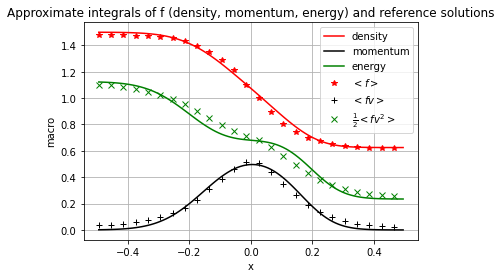

In [13]:
def average_op(model, t_x, vwquads):
        tx = torch.cat(t_x, -1)[:, None, :]
        v, w = vwquads
        mult_fact = torch.ones((tx.shape[0], v.shape[0], 1))
        fn = model(torch.cat([tx * mult_fact, v[..., None] * mult_fact], -1)).cpu()
        return torch.sum(fn * w[..., None], axis=-2)

v, w = np.polynomial.legendre.leggauss(32)
v = 0.5 * (v + 1.0) * 20 - 10
w = 0.5 * 20 * w
vquads = torch.Tensor(v)
wquads = torch.Tensor(w)

model_f = Sol[0]
avg_f_1 = average_op(model_f, [ref_t, ref_x], [vquads, wquads]).detach().numpy()
approx_density = avg_f_1
avg_f_2 = average_op(model_f, [ref_t, ref_x], [vquads, wquads * vquads]).detach().numpy()
approx_momentum = avg_f_2
avg_f_3 = average_op(model_f, [ref_t, ref_x], [vquads, wquads * vquads ** 2]).detach().numpy()
approx_energy = 0.5 * avg_f_3

plt.plot(ref_x, ref_rho, "r", label = "density")
plt.plot(ref_x, ref_momentum, "k", label = "momentum")
plt.plot(ref_x, ref_energy, "g", label = "energy")

plt.plot(ref_x, approx_density, "r*", markevery= 4, label = r"$<f>$")
plt.plot(ref_x, approx_momentum, "k+", markevery= 4, label = r"$<fv>$")
plt.plot(ref_x, approx_energy, "gx", markevery= 4, label = r"$\frac{1}{2} <fv^2>$")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("macro")
plt.title("Approximate integrals of f (density, momentum, energy) and reference solutions")
plt.savefig("./figure/solution_f.pdf")
plt.show()
plt.close()



In [ ]:
# # jupyter notebook to python
# try:   
#     !jupyter nbconvert --to python bgk_example.ipynb
# except:
#     pass